In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

We will be running 3 models: 1) KNN, 2) Random Forest, 3) Logistic Regression. First we will introduce our data.

In [2]:
heart = pd.read_csv("heart.csv")
heart.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Now we will describe each variable. 

age: in years

sex: 0 - Female, 1 - Male

cp: types of chest pain. 0 - Typical Angina, 1 - Atypical Angina, 2 - non-anginal pain, 3 - Asymptomatic 

trtbps: resting systolic blood pressure(mm Hg). Measures the pressure in you arteries when your heart beats.

chol: serum cholesterol (HDL, LDL and triglycerides) (mg/dl)

fbs: fasting blood sugar (1 if >= 120 mg/dl, 0 otherwise)

restecg: resting electrocardiographic results: 0 - normal, 1 - ST-T wave abnormality, 2 - showing probablie or definite left ventricular hypertrophy.

thalachh: maximum heart rate achieved during strenuous exercise

exng: exercise induced heart pain: 1 - yes, 0 - no

oldpeak: ST depression induced from exercise

slp: slope of the peak exercise segment ST wave segment

caa: coronary arteries with an abnormality(0-4)

thall: Thallium stress test to check blood flow.


In [4]:
heart.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Get dummie variables for categorical data.

In [5]:
cp = pd.get_dummies(heart["cp"])
cp = cp.rename({0:"TA", 1:"ATA", 2:"NAP", 3:"ASY"}, axis = 1)

In [6]:
restecg = pd.get_dummies(heart["restecg"])
restecg = restecg.rename({0:"Normal", 1:"STT_ab",2:"hyper"}, axis = 1)

In [7]:
slp = pd.get_dummies(heart["slp"])
slp = slp.rename({0:"up", 1:"flat", 2:"down"}, axis = 1)

In [8]:
thall = pd.get_dummies(heart["thall"])
thall.drop(columns = 0, inplace = True)
thall = thall.rename({1:"normal", 2:"FD", 3:"RD"}, axis = 1)

In [9]:
heart = pd.concat([heart,cp,restecg,slp,thall], axis = 1)
heart.drop(columns = ["cp", "restecg", "slp", "thall"], inplace = True)
heart

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,caa,output,...,ASY,Normal,STT_ab,hyper,up,flat,down,normal,FD,RD
0,63,1,145,233,1,150,0,2.3,0,1,...,1,1,0,0,1,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,1,...,0,0,1,0,1,0,0,0,1,0
2,41,0,130,204,0,172,0,1.4,0,1,...,0,1,0,0,0,0,1,0,1,0
3,56,1,120,236,0,178,0,0.8,0,1,...,0,0,1,0,0,0,1,0,1,0
4,57,0,120,354,0,163,1,0.6,0,1,...,0,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,140,241,0,123,1,0.2,0,0,...,0,0,1,0,0,1,0,0,0,1
299,45,1,110,264,0,132,0,1.2,0,0,...,1,0,1,0,0,1,0,0,0,1
300,68,1,144,193,1,141,0,3.4,2,0,...,0,0,1,0,0,1,0,0,0,1
301,57,1,130,131,0,115,1,1.2,1,0,...,0,0,1,0,0,1,0,0,0,1


In [10]:
value = heart.pop("output")
heart.insert(22, "output", value)
heart

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,caa,TA,...,Normal,STT_ab,hyper,up,flat,down,normal,FD,RD,output
0,63,1,145,233,1,150,0,2.3,0,0,...,1,0,0,1,0,0,1,0,0,1
1,37,1,130,250,0,187,0,3.5,0,0,...,0,1,0,1,0,0,0,1,0,1
2,41,0,130,204,0,172,0,1.4,0,0,...,1,0,0,0,0,1,0,1,0,1
3,56,1,120,236,0,178,0,0.8,0,0,...,0,1,0,0,0,1,0,1,0,1
4,57,0,120,354,0,163,1,0.6,0,1,...,0,1,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,140,241,0,123,1,0.2,0,1,...,0,1,0,0,1,0,0,0,1,0
299,45,1,110,264,0,132,0,1.2,0,0,...,0,1,0,0,1,0,0,0,1,0
300,68,1,144,193,1,141,0,3.4,2,1,...,0,1,0,0,1,0,0,0,1,0
301,57,1,130,131,0,115,1,1.2,1,1,...,0,1,0,0,1,0,0,0,1,0


#### What is the naive classifier?

In [11]:
naive = round(heart[heart["output"] == 1]["output"].sum()/len(heart), 3)
naive

0.545

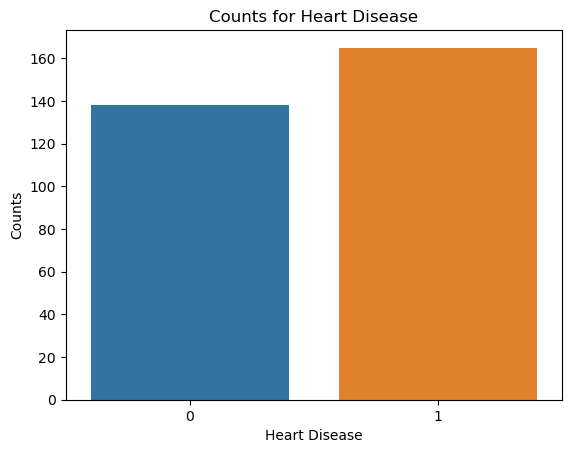

In [12]:
sns.countplot(data = heart, x = "output")
plt.title("Counts for Heart Disease")
plt.xlabel("Heart Disease")
plt.ylabel("Counts")
plt.savefig("Counts.png", bbox_inches = "tight")
plt.show()

If we said "yes" to every observation. Then we would be correct 54.5% of the time. We need to check and see if our models beat this.

Now we will run 10-fold cross validation on our KNN and Random Forest to get adequate tuning parameters. For the Random Forest we will use 5 features, since this is roughly the square root of the number of features.

In [14]:
X = heart.iloc[:,:-1]
y = heart.iloc[:,-1]
kf = KFold(n_splits = 10, shuffle = True)

In [15]:
accuracy = []
for i in range(1, 200):
    knn = KNeighborsClassifier(n_neighbors = i)
    cv_score = cross_val_score(knn, X, y, cv = kf)
    accuracy.append(cv_score.mean())

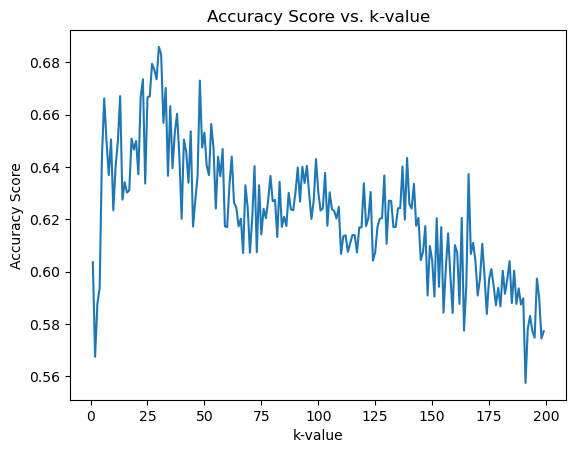

In [16]:
plt.plot(np.arange(1,200), accuracy)
plt.xlabel("k-value")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Score vs. k-value")
plt.savefig("CVKNN.png", bbox_inches = "tight")
plt.show()

We will use a k-value of 15, since this roughly maximizes our accuracy score.

In [ ]:
forest = RandomForestClassifier(random_state = 10, max_features = 5)
parameters = {'max_depth':np.arange(1,20), 'n_estimators':np.arange(5,70,5)}
rf = GridSearchCV(forest, parameters, cv = kf).fit(X,y)

In [ ]:
rf.best_params_

Max_depth of 6 and n_estimators of 40

Backward Variable selection was done for the Logistic Regression in R

We will now train our models

In [17]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.20, random_state = 10)

# KNN

In [18]:
knn = KNeighborsClassifier(n_neighbors = 15)
knn.fit(xtrain, ytrain)

pred = knn.predict(xtest)
y_score = knn.predict_proba(xtest)[:,1]
score_k = accuracy_score(ytest, pred)
cm_k = confusion_matrix(ytest, pred)
fpr_k, tpr_k, _ = roc_curve(ytest, y_score)
auc_k = round(roc_auc_score(ytest, y_score),3)

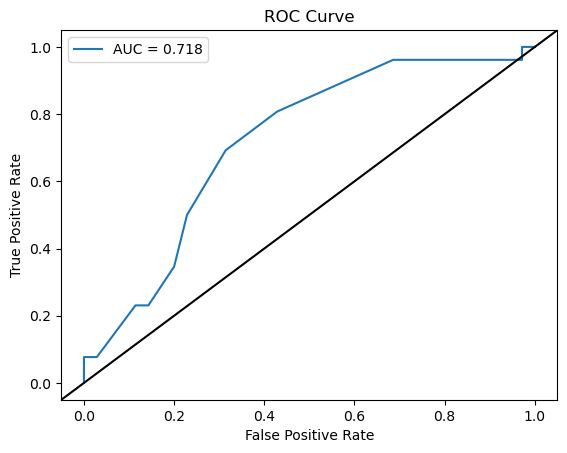

In [19]:
plt.plot(fpr_k, tpr_k, label = "AUC = " + str(auc_k))
plt.legend()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.axline([0,0], [1,1], color = "k")
plt.show()

In [20]:
print(score_k)
cm_k

0.6721311475409836


array([[20, 15],
       [ 5, 21]], dtype=int64)

# Random Forest

In [21]:
forest = RandomForestClassifier(max_depth = 6, n_estimators = 40, max_features = 5, random_state = 10)
forest.fit(xtrain, ytrain)

pred = forest.predict(xtest)
y_score = forest.predict_proba(xtest)[:,1]
score_t = accuracy_score(ytest, pred)
cm_t = confusion_matrix(ytest, pred)
fpr_rf, tpr_rf, _ = roc_curve(ytest, y_score)
auc_rf = round(roc_auc_score(ytest, y_score),3)

### Feature Importance

In [22]:
df_dic = {"name":[], "importance":[]}
name = heart.columns
for name, importance in zip(heart[name], forest.feature_importances_):
    print(name, "=", importance)
    df_dic["name"].append(name) 
    df_dic["importance"].append(importance)

age = 0.05938205518593688
sex = 0.023926170602916734
trtbps = 0.05906390799503465
chol = 0.06166324065146796
fbs = 0.008058139092825637
thalachh = 0.10883158512373096
exng = 0.03092492930983099
oldpeak = 0.08222240539903378
caa = 0.15194596375727276
TA = 0.12268020588757425
ATA = 0.014253430955551294
NAP = 0.028073837350611242
ASY = 0.011567875641741134
Normal = 0.009481710736188713
STT_ab = 0.010282173022782233
hyper = 0.000873089336982826
up = 0.0015799921886376779
flat = 0.025224081531975463
down = 0.03460923690771552
normal = 0.003988238706732051
FD = 0.11218227294280836
RD = 0.039185457672648916


In [23]:
df_dic
df = pd.DataFrame.from_dict(df_dic)
df = df.sort_values(by = "importance", ascending = False).reset_index(drop = True)

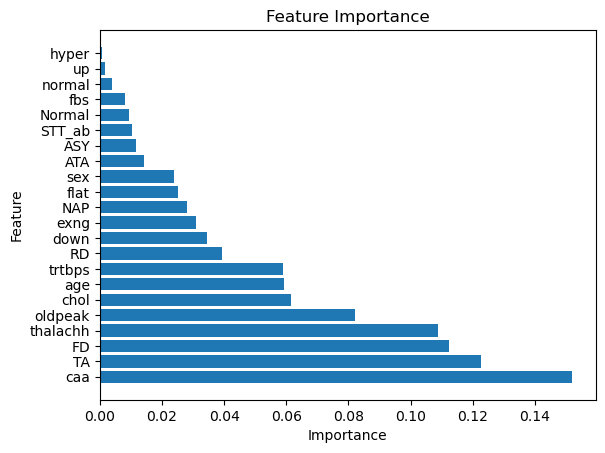

In [24]:
plt.barh(df["name"], df["importance"])
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.savefig("Importance.png", bbox_inches = "tight")
plt.show()

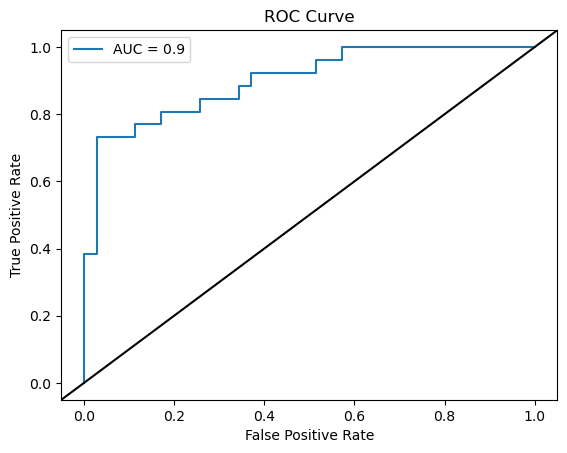

In [25]:
plt.plot(fpr_rf, tpr_rf, label = "AUC = " + str(auc_rf))
plt.legend()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.axline([0,0], [1,1], color = "k")
plt.show()

In [26]:
print(score_t)
cm_t

0.7868852459016393


array([[27,  8],
       [ 5, 21]], dtype=int64)

# Logistic Regression

##### Using all features

In [27]:
log_reg = LogisticRegression(max_iter = 5000)
log_reg.fit(xtrain,ytrain)

LogisticRegression(max_iter=5000)

In [28]:
pred = log_reg.predict(xtest)
y_score = log_reg.predict_proba(xtest)[:,1]
score_lr_1 = accuracy_score(ytest, pred)
cm_lr_1 = confusion_matrix(ytest, pred)
fpr_lr_1, tpr_lr_1, _ = roc_curve(ytest, y_score)
auc_lr_1 = round(roc_auc_score(ytest, y_score),3)

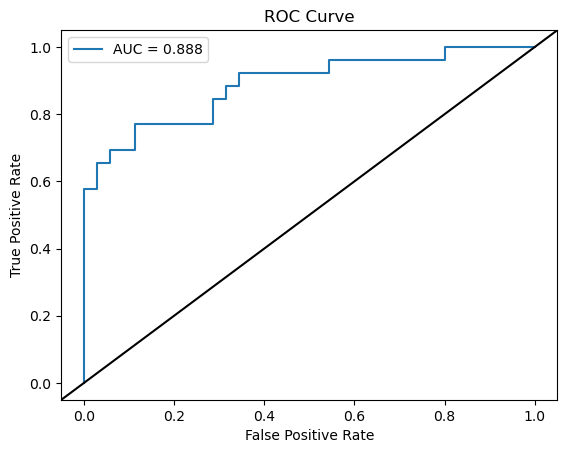

In [29]:
plt.plot(fpr_lr_1, tpr_lr_1, label = "AUC = " + str(auc_lr_1))
plt.legend()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.axline([0,0], [1,1], color = "k")
plt.show()

In [30]:
print(score_lr_1)
cm_lr_1

0.7868852459016393


array([[28,  7],
       [ 6, 20]], dtype=int64)

#### After Feature Selection

In [31]:
heart = heart[["trtbps", "thalachh", "ATA", "exng", "STT_ab", "normal", "flat", "oldpeak",
              "sex", "FD", "caa", "TA", "output"]]
X = heart.iloc[:,:-1]
X = sm.add_constant(X)
y = heart.iloc[:,-1]
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.20, random_state = 10)
heart

,trtbps,thalachh,ATA,exng,STT_ab,normal,flat,oldpeak,sex,FD,caa,TA,output
0,145,150,0,0,0,1,0,2.3,1,0,0,0,1
1,130,187,0,0,1,0,0,3.5,1,1,0,0,1
2,130,172,1,0,0,0,0,1.4,0,1,0,0,1
3,120,178,1,0,1,0,0,0.8,1,1,0,0,1
4,120,163,0,1,1,0,0,0.6,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,140,123,0,1,1,0,1,0.2,0,0,0,1,0
299,110,132,0,0,1,0,1,1.2,1,0,0,0,0
300,144,141,0,0,1,0,1,3.4,1,0,2,1,0
301,130,115,0,1,1,0,1,1.2,1,0,1,1,0


In [32]:
log_reg = LogisticRegression(max_iter = 5000)
log_reg.fit(xtrain,ytrain)

LogisticRegression(max_iter=5000)

In [33]:
log_reg.coef_

array([[-0.00502952, -0.01772974,  0.02055969, -0.25973118, -0.6767005 ,
         0.35781722,  0.42740326, -0.80904563, -0.32042748, -1.14390609,
         0.94052447, -0.91517492, -1.53579651]])

In [34]:
pred = log_reg.predict(xtest)
y_score = log_reg.predict_proba(xtest)[:,1]
score_lr = accuracy_score(ytest, pred)
cm_lr = confusion_matrix(ytest, pred)
fpr_lr, tpr_lr, _ = roc_curve(ytest, y_score)
auc_lr = round(roc_auc_score(ytest, y_score),3)

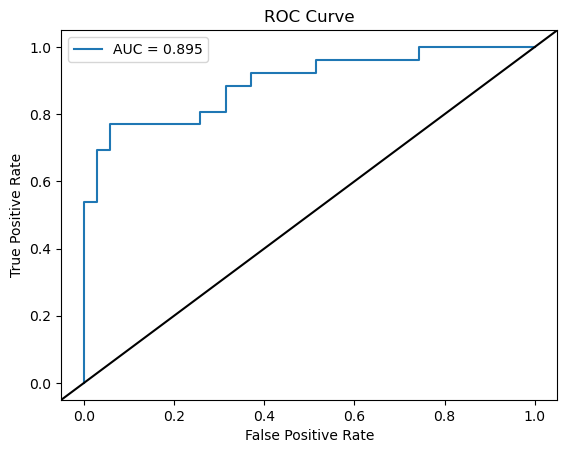

In [35]:
plt.plot(fpr_lr, tpr_lr, label = "AUC = " + str(auc_lr))
plt.legend()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")
plt.axline([0,0], [1,1], color = "k")
plt.show()

In [36]:
print(score_lr)
cm_lr

0.7704918032786885


array([[27,  8],
       [ 6, 20]], dtype=int64)

# Results

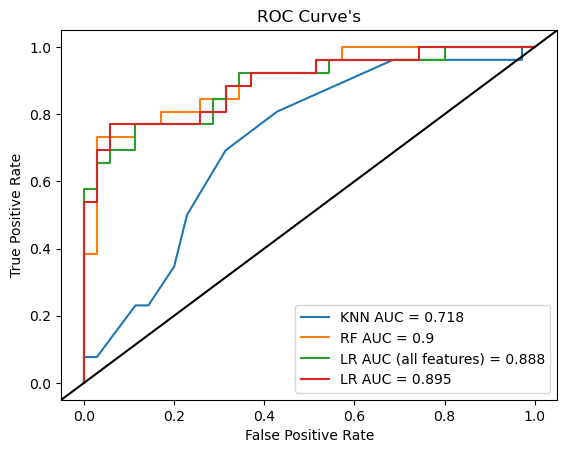

In [38]:
plt.plot(fpr_k, tpr_k,label = "KNN AUC = " + str(auc_k))
plt.plot(fpr_rf, tpr_rf, label = "RF AUC = " + str(auc_rf))
plt.plot(fpr_lr_1, tpr_lr_1, label = "LR AUC (all features) = " + str(auc_lr_1))
plt.plot(fpr_lr, tpr_lr, label = "LR AUC = " + str(auc_lr))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve's")
plt.legend()
plt.axline([0,0], [1,1], color = "k")
plt.savefig("ROC.png", bbox_inches = "tight")
plt.show()

In [39]:
print("KNN Accuracy Score: " + str(round(score_k,4)))
print("Random Forest Accuracy Score: " + str(round(score_t,4)))
print("Logistic Regression Accuracy Score (all features): " + str(round(score_lr_1,4)))
print("Logistic Regression Accuracy Score: " + str(round(score_lr,4)))

KNN Accuracy Score: 0.6721
Random Forest Accuracy Score: 0.7869
Logistic Regression Accuracy Score (all features): 0.7869
Logistic Regression Accuracy Score: 0.7705


In [40]:
print("KNN Confusion Matrix: ")
print(cm_k)
print("Random Forest Confusion Matrix: ")
print(cm_t)
print("Logistic Regression Confusion Matrix (all features): ")
print(cm_lr_1)
print("Logistic Regression Confusion Matrix: ")
print(cm_lr)

KNN Confusion Matrix: 
[[20 15]
 [ 5 21]]
Random Forest Confusion Matrix: 
[[27  8]
 [ 5 21]]
Logistic Regression Confusion Matrix (all features): 
[[28  7]
 [ 6 20]]
Logistic Regression Confusion Matrix: 
[[27  8]
 [ 6 20]]
